A diferencia de 3.2_kitti_carla, se disminuyó el dropout rate de 0.5 a 0.25 y se agregaron más capas de dropout

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import imageio.v2 as io
import cv2

from data_gen_distance import *
from unet_model import *

Total distance images: 5000
Train distance images: 4500
Validation distance images: 500
****************************************
Input image resolution: 16 x 2048 x 1
Output image resolution: 64 x 2048 x 1
Upscaling factor: x4
****************************************


### Configuración GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

#Hacer que tf vaya asignando solo la cantidad de memoria requerida
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Generación del dataset de entrenamiento y prueba

### Empleando generadores

(8, 16, 2048, 1)


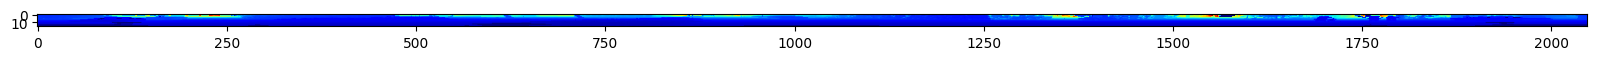

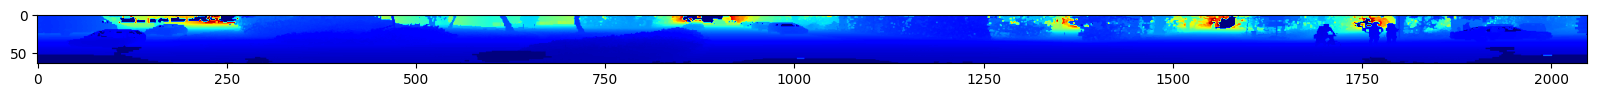

In [5]:
batch_size=8

#Training dataset
train_dataset_example = tf.data.Dataset.from_generator(generator=train_data_generator, output_types=(tf.float32, tf.float32))
train_dataset_example = train_dataset_example.batch(batch_size)

#Validation dataset
valid_dataset_example = tf.data.Dataset.from_generator(generator=valid_data_generator, output_types=(tf.float32, tf.float32))
valid_dataset_example = valid_dataset_example.batch(batch_size)


for a, b in valid_dataset_example.take(1):
    print(a.shape)
    plt.figure(figsize=(20,20))
    plt.imshow(a[0], cmap='jet')
    plt.figure(figsize=(20,20))
    plt.imshow(b[0], cmap='jet')
    plt.show()

#Test dataset
#test_dataset_example = tf.data.Dataset.from_generator(generator=test_data_generator, output_types=(tf.float32, tf.float32))
#test_dataset_example = test_dataset_example.batch(batch_size)

## Modelo

In [3]:
model = Unet()
model.summary()

#from keras.utils.vis_utils import plot_model
#plot_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 2048, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 32, 2048, 64  640        ['input_1[0][0]']                
 ose)                           )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 2048, 64  256        ['conv2d_transpose[0][0]']       
 alization)                     )                                                             

## Entrenamiento con generadores

In [4]:
def get_check_callback():
    path_check_folder = os.path.join(path_folder, r'LIDAR_super_resolution\Scripts\unet\3_model_fit_keras\3.9_kitti_distance_ego_compensed_filtered\model_mae')
    path_csv_check = os.path.join(path_folder, r'LIDAR_super_resolution\Scripts\unet\3_model_fit_keras\3.9_kitti_distance_ego_compensed_filtered\model_mae\csv_train.csv')
    #tensorboard_logs_folder = os.path.join(path_folder, r'LIDAR_super_resolution\Scripts\unet_based\checkpoints3\tensorboard_logs')
   
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(path_check_folder,'best_{epoch:02d}_{val_loss:.4f}.h5'),#path_check_folder,
                                                                   save_weights_only=False,
                                                                   monitor='val_loss',
                                                                   verbose=0,
                                                                   mode='min',
                                                                   save_best_only=True)
    csv_logger = keras.callbacks.CSVLogger(path_csv_check)
    
    #tensorboard_model = keras.callbacks.TensorBoard(log_dir=tensorboard_logs_folder)
    #command = 'tensorboard --logdir=' + os.path.join(tensorboard_logs_folder, 'logs') + ' &'
    #os.system(command)     
    
    return model_checkpoint_callback, csv_logger#, tensorboard_model

epochs = 200
batch_size=8

def train():

    train_dataset = tf.data.Dataset.from_generator(generator=train_data_generator, output_types=(tf.float32, tf.float32))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.__iter__()

    valid_dataset = tf.data.Dataset.from_generator(generator=valid_data_generator, output_types=(tf.float32, tf.float32))
    valid_dataset = valid_dataset.batch(batch_size)
    valid_dataset = valid_dataset.__iter__()
    
    #model_checkpoint_callback, csv_logger, tensorboard_model = get_check_callback()
    model_checkpoint_callback, csv_logger = get_check_callback()

    model.fit(train_dataset,
              validation_data=valid_dataset,
              validation_steps=round(len(valid_urls)/batch_size),
              epochs=epochs,
              steps_per_epoch=round(len(train_urls)/batch_size),
              verbose=1,
              #callbacks=[model_checkpoint_callback, csv_logger, tensorboard_model])
              callbacks=[model_checkpoint_callback, csv_logger])

train()
model.save(os.path.join(path_folder, r'LIDAR_super_resolution\Scripts\unet\3_model_fit_keras\3.9_kitti_distance_ego_compensed_filtered\model_mae\final.h5'))

Epoch 1/200
562/562 [==============================] - 456s 788ms/step - loss: 0.0359 - val_loss: 0.0710
Epoch 2/200
562/562 [==============================] - 445s 791ms/step - loss: 0.0231 - val_loss: 0.0213
Epoch 3/200
562/562 [==============================] - 448s 797ms/step - loss: 0.0203 - val_loss: 0.0408
Epoch 4/200
562/562 [==============================] - 466s 830ms/step - loss: 0.0195 - val_loss: 0.0193
Epoch 5/200
562/562 [==============================] - 461s 820ms/step - loss: 0.0193 - val_loss: 0.0326
Epoch 6/200
562/562 [==============================] - 461s 820ms/step - loss: 0.0191 - val_loss: 0.0225
Epoch 7/200
562/562 [==============================] - 461s 821ms/step - loss: 0.0179 - val_loss: 0.0185
Epoch 8/200
562/562 [==============================] - 461s 820ms/step - loss: 0.0168 - val_loss: 0.0328
Epoch 9/200
562/562 [==============================] - 466s 828ms/step - loss: 0.0165 - val_loss: 0.0146
Epoch 10/200
562/562 [==============================] -